# Data Reading

Try to minimize amount of assumptions about the data, especially when it's coming from an external source.

In [2]:
import json
import pandas as po
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro
from scipy.stats import ttest_ind

from agg import * # my custom functions


data = po.read_csv("data/Cleaned_airports.csv", index_col=0, parse_dates=['Time.Label'], infer_datetime_format=True)
data

,Airport.Code,Airport.Location,Airport.Name,Statistics.# of Delays.Carrier,Statistics.# of Delays.Late Aircraft,Statistics.# of Delays.National Aviation System,Statistics.# of Delays.Security,Statistics.# of Delays.Total,Statistics.# of Delays.Weather,Statistics.Carriers.Names,...,Statistics.Minutes Delayed.Carrier,Statistics.Minutes Delayed.Late Aircraft,Statistics.Minutes Delayed.National Aviation System,Statistics.Minutes Delayed.Security,Statistics.Minutes Delayed.Total,Statistics.Minutes Delayed.Weather,Time.Label,Time.Month,Time.Month Name,Time.Year
0,ATL,"Atlanta, GA",Hartsfield-Jackson Atlanta International,1009,1275,3217,17,5846,328,"American Airlines Inc.,JetBlue Airways,Contine...",...,61606,68335,118831,518,268764,19474,2003-06-01,6,June,2003
1,TPA,"Tampa, FL",Tampa International,226,327,524,3,1122,42,"American Airlines Inc.,JetBlue Airways,Contine...",...,11012,18558,19078,112,51364,2604,2003-06-01,6,June,2003
2,SLC,"Salt Lake City, UT",Salt Lake City International,363,290,352,15,1056,36,"American Airlines Inc.,JetBlue Airways,Contine...",...,16227,13883,10512,556,42863,1685,2003-06-01,6,June,2003
3,SFO,"San Francisco, CA",San Francisco International,416,312,1080,14,1881,59,"American Airlines Inc.,Alaska Airlines Inc.,Co...",...,22673,17879,45407,1138,90487,3390,2003-06-01,6,June,2003
4,SEA,"Seattle, WA",Seattle/Tacoma International,448,552,454,28,1518,36,"American Airlines Inc.,Alaska Airlines Inc.,Je...",...,22647,28119,13860,1097,68673,2950,2003-06-01,6,June,2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409,BOS,"Boston, MA",Logan International,515,756,775,3,2092,43,"Pinnacle Airlines Inc.,American Airlines Inc.,...",...,29259,56771,38108,118,127224,2968,2013-03-01,3,March,2013
3410,ATL,"Atlanta, GA",Hartsfield-Jackson Atlanta International,1182,2139,1990,3,5479,165,"Pinnacle Airlines Inc.,American Airlines Inc.,...",...,98034,133049,87848,198,337684,18555,2013-03-01,3,March,2013
3411,MSP,"Minneapolis, MN",Minneapolis-St Paul International,452,665,876,2,2074,79,"Pinnacle Airlines Inc.,American Airlines Inc.,...",...,33579,40715,38518,64,120223,7347,2013-03-01,3,March,2013
3412,FLL,"Fort Lauderdale, FL",Fort Lauderdale-Hollywood International,473,497,858,8,1888,52,"American Airlines Inc.,Alaska Airlines Inc.,Je...",...,27568,34420,34436,194,100443,3825,2013-03-01,3,March,2013


In [5]:
x = None
with open("data/airports.json", 'r') as f:
    x = f.read() # 

In [6]:
# initial read
#po.read_json("data/airports.json", orient='records')

In [4]:
#data = po.json_normalize(json.loads(x))
#data

## Data Cleaning

In [7]:
# INITIAL DATA CLEANING
data = po.json_normalize(json.loads(x))

# converting Time.Month and Time.Year string values to integers
data['Time.Month'] = data['Time.Month'].astype(int)
data['Time.Year'] = data['Time.Year'].astype(int)

# converting numeric statistics columns to integers
for col in data.columns:
    if "Statistics" not in col:
        continue
    if col == "Statistics.Carriers.Names":
        continue

    try:
        data[col] = data[col].astype(int)
    except:
        print(col)


# converting Time.Label to Datetime
data['Time.Label'] = po.to_datetime(data['Time.Label'])
data = data.sort_values(['Time.Label']).reset_index(drop=True)

# Splitting Airport.Name into Airport.Location and Airport.Name columns
split_column = data['Airport.Name'].str.split(':')
data['Airport.Location'] = split_column.apply(lambda r: r[0])
data['Airport.Name'] = split_column.apply(lambda r: r[1]).str.strip()

# Creating Total # of Delays column (note: nearly equivalent to Statistics.Flights.Delayed)
data['Statistics.# of Delays.Total'] = data[['Statistics.# of Delays.Carrier',
       'Statistics.# of Delays.Late Aircraft',
       'Statistics.# of Delays.National Aviation System',
       'Statistics.# of Delays.Security', 
       'Statistics.# of Delays.Weather']].sum(axis=1)
       
# Stripping white space
data['Airport.Name'] = data['Airport.Name'].str.strip()

data = data.reindex(sorted(data.columns), axis=1)
data.head()

,Airport.Code,Airport.Location,Airport.Name,Statistics.# of Delays.Carrier,Statistics.# of Delays.Late Aircraft,Statistics.# of Delays.National Aviation System,Statistics.# of Delays.Security,Statistics.# of Delays.Total,Statistics.# of Delays.Weather,Statistics.Carriers.Names,...,Statistics.Minutes Delayed.Carrier,Statistics.Minutes Delayed.Late Aircraft,Statistics.Minutes Delayed.National Aviation System,Statistics.Minutes Delayed.Security,Statistics.Minutes Delayed.Total,Statistics.Minutes Delayed.Weather,Time.Label,Time.Month,Time.Month Name,Time.Year
0,ATL,"Atlanta, GA",Hartsfield-Jackson Atlanta International,1009,1275,3217,17,5846,328,"American Airlines Inc.,JetBlue Airways,Contine...",...,61606,68335,118831,518,268764,19474,2003-06-01,6,June,2003
1,TPA,"Tampa, FL",Tampa International,226,327,524,3,1122,42,"American Airlines Inc.,JetBlue Airways,Contine...",...,11012,18558,19078,112,51364,2604,2003-06-01,6,June,2003
2,SLC,"Salt Lake City, UT",Salt Lake City International,363,290,352,15,1056,36,"American Airlines Inc.,JetBlue Airways,Contine...",...,16227,13883,10512,556,42863,1685,2003-06-01,6,June,2003
3,SFO,"San Francisco, CA",San Francisco International,416,312,1080,14,1881,59,"American Airlines Inc.,Alaska Airlines Inc.,Co...",...,22673,17879,45407,1138,90487,3390,2003-06-01,6,June,2003
4,SEA,"Seattle, WA",Seattle/Tacoma International,448,552,454,28,1518,36,"American Airlines Inc.,Alaska Airlines Inc.,Je...",...,22647,28119,13860,1097,68673,2950,2003-06-01,6,June,2003


In [8]:
data.to_csv("data/Cleaned_airports.csv")

## Data Checking
Because the last thing you want is all the work and results you do/obtain from this point forward to be completely defunct because you didn't clean the data properly/made assumptions about the data you shouldn't have. (Experienced this depression when working on my trading system)

In [9]:
dc = __import__("data-check")

dc.check_month_year_label(data)
dc.check_airport_name_code_uniqueness(data)
dc.check_carrier_list_length(data)
dc.check_nonnegative_values(data)

print("Passed all checks!")

Passed all checks!


In [10]:
# Manual inspection
for col in data.columns:
    print(col, data[col].unique())

Airport.Code ['ATL' 'TPA' 'SLC' 'SFO' 'SEA' 'SAN' 'PHX' 'PHL' 'ORD' 'MSP' 'MIA' 'MDW'
 'MCO' 'LGA' 'PDX' 'LAS' 'LAX' 'BWI' 'CLT' 'DCA' 'DEN' 'DFW' 'BOS' 'EWR'
 'FLL' 'IAD' 'IAH' 'JFK' 'DTW']
Airport.Location ['Atlanta, GA' 'Tampa, FL' 'Salt Lake City, UT' 'San Francisco, CA'
 'Seattle, WA' 'San Diego, CA' 'Phoenix, AZ' 'Philadelphia, PA'
 'Chicago, IL' 'Minneapolis, MN' 'Miami, FL' 'Orlando, FL' 'New York, NY'
 'Portland, OR' 'Las Vegas, NV' 'Los Angeles, CA' 'Baltimore, MD'
 'Charlotte, NC' 'Washington, DC' 'Denver, CO' 'Dallas/Fort Worth, TX'
 'Boston, MA' 'Newark, NJ' 'Fort Lauderdale, FL' 'Houston, TX'
 'Detroit, MI']
Airport.Name ['Hartsfield-Jackson Atlanta International' 'Tampa International'
 'Salt Lake City International' 'San Francisco International'
 'Seattle/Tacoma International' 'San Diego International'
 'Phoenix Sky Harbor International' 'Philadelphia International'
 "Chicago O'Hare International" 'Minneapolis-St Paul International'
 'Miami International' 'Chicago Midway

# First Glance

## How many airports are present in this dataset?

In [ ]:
display(data['Airport.Name'].unique().shape[0], 
        data['Airport.Code'].unique().shape[0]
        )

29

29

## What is the time range of the dataset? 

In [ ]:
data['Time.Label'].iloc[[0, -1]] # get first and last value of column

0      2003-06-01
3413   2013-03-01
Name: Time.Label, dtype: datetime64[ns]

## Choose two fields that should be numeric and find the min, max, mean, and median across the whole dataset.

In [ ]:
data[["Statistics.# of Delays.Late Aircraft", "Statistics.Flights.Delayed"]].describe()

,Statistics.# of Delays.Late Aircraft,Statistics.Flights.Delayed
count,3414.000000,3414.000000
mean,782.491506,2457.794962
std,555.891516,1776.132313
min,90.000000,283.000000
25%,423.000000,1317.000000
50%,619.000000,1936.000000
75%,951.000000,3014.000000
max,4483.000000,13699.000000


## Choose a field that should be numeric and plot the value over time. 

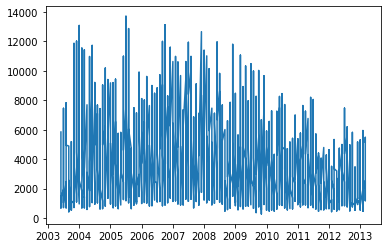

In [ ]:
plt.plot(data['Time.Label'],data["Statistics.Flights.Delayed"]);plt.show()

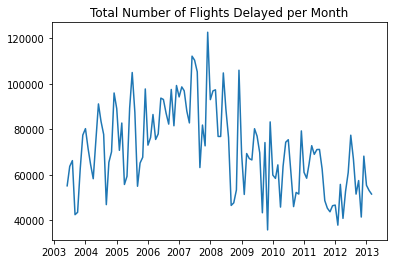

In [ ]:
# Total number of flights delayed each month
flights_delayed_agg_monthly = data.groupby('Time.Label').sum()["Statistics.Flights.Delayed"].values
plt.plot(data['Time.Label'].unique(), flights_delayed_agg_monthly)
plt.title("Total Number of Flights Delayed per Month")
plt.show()

## Create a frequency table for how many of each airline are hosted at each airport in the dataset.
Which airport has the most carriers in this dataset?
Which airport has the least?

In [ ]:
# Max number of carriers per airport, across any given month

subset = data[['Airport.Name','Statistics.Carriers.Names']]
subset['Frequency'] = subset['Statistics.Carriers.Names'].str.split(",").apply(len)

(subset.groupby('Airport.Name').agg(max)
.sort_values(by='Frequency')
.drop('Statistics.Carriers.Names', axis=1)
.reset_index()
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Airport.Name,Frequency
0,Chicago Midway International,13
1,Fort Lauderdale-Hollywood International,13
2,Miami International,13
3,John F. Kennedy International,13
4,Salt Lake City International,14
5,Portland International,14
6,Baltimore/Washington International Thurgood Ma...,15
7,Seattle/Tacoma International,15
8,Ronald Reagan Washington National,15
9,Newark Liberty International,15


Quick sanity check: LaGuardia is a small airport -- only 680 acres -- and primarily focuses on domestic flights. Makes sense there's less carriers.

Orlando International is one of the largest airports in the US -- 12600 acres -- and does both domestic and international flights. Makes sense they have more carriers.

In [ ]:
# Historical total number of unique carriers at each airport
subset = data[['Airport.Name','Statistics.Carriers.Names']]

# Frequency Table
(subset.groupby('Airport.Name').agg(lambda g: count_unique_carriers(g))
.sort_values(by='Statistics.Carriers.Names')
.rename(columns={'Statistics.Carriers.Names':'Frequency'})
.reset_index()
)

,Airport.Name,Frequency
0,Miami International,16
1,Chicago Midway International,17
2,Tampa International,17
3,Portland International,17
4,George Bush Intercontinental/Houston,17
5,Salt Lake City International,17
6,Charlotte Douglas International,19
7,Minneapolis-St Paul International,19
8,Detroit Metro Wayne County,19
9,John F. Kennedy International,19


## How many of the airports in this dataset are host to ‘Northwest Airlines’?


In [ ]:
%%timeit

# Method 1. iterate over all records

airports_with_nw = set()

for i, row in subset.iterrows():
    if "Northwest Airlines" in row['Statistics.Carriers.Names']:
        airports_with_nw.add(row['Airport.Name'])

airports_with_nw

1 loop, best of 5: 182 ms per loop


In [ ]:
%%timeit
# Method 2. slight change to groupby agg function

def unique_carriers(df : po.DataFrame) -> int:
    list_of_carriers = df.str.split(",").values

    set_of_carriers = set()
    for lst in list_of_carriers:
        set_of_carriers.update(lst)

    return (set_of_carriers) 
 
subset.groupby('Airport.Name').agg(lambda g: "Northwest Airlines Inc." in unique_carriers(g))

100 loops, best of 5: 17.8 ms per loop


All of them host Northwest.

## Which other fields might be of interest to the client?
How do they contribute to solving the problem outlined above?
What types of statistics might you want to calculate to describe these fields to the client? The client would like to know which airports to avoid and which carriers to book for future travel.

There are quite a few simple, intuitive metrics that we can look at (possibly list out in dashboard):
* top x airports that have the greatest chance of being delayed due to security (e.g., most unsafe airport)
* top x airports that have the greatest chance of being on time (# on time flights / # flights total)
* top x airports that have the lowest chance of having a delayed flight (# delayed flights / # flights total)
* top x airports that have the lowest chance of having a cancelled flight (# cancelled flights / # flights total)
* top x airports with the lowest average delay per flight (# minutes delayed / # flights delayed)

We are tasked with comparing airports, so it would be more informative to measure an airport's "goodness" relative to other airports. This implies the analysis of proportions (e.g. of delays) rather than the absolute numbers.

Additionally, the data is essentially a time series, so it would be productive to incorporate this in metrics and subsequent analyses. (E.g., during 2008 we see a spike in delayed flights across all airports -- while all did "bad", which airport did the "least bad"?)

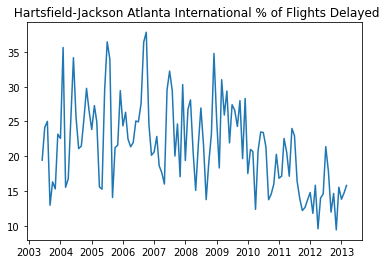

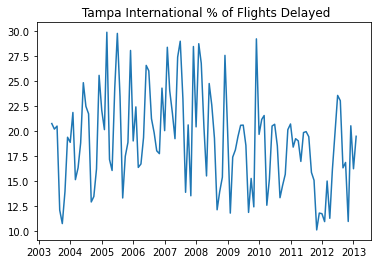

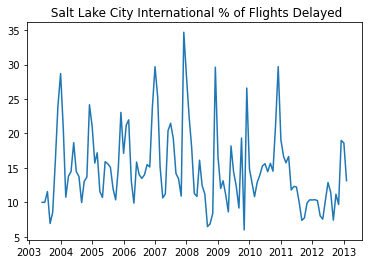

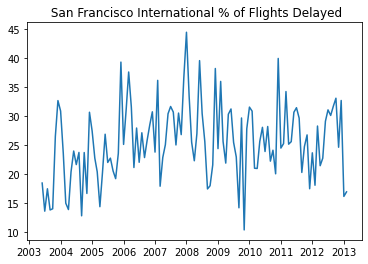

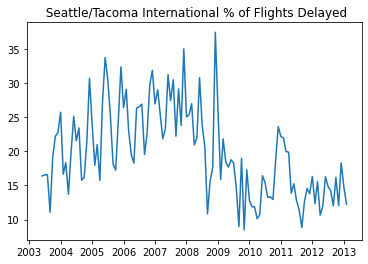

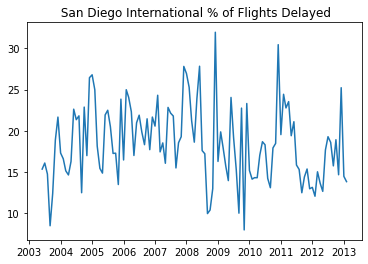

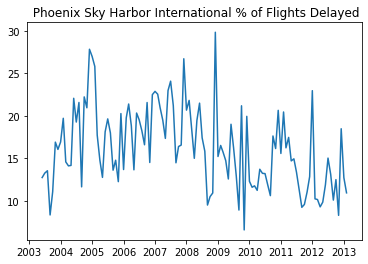

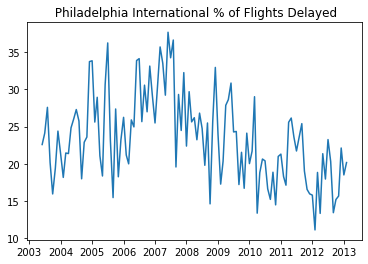

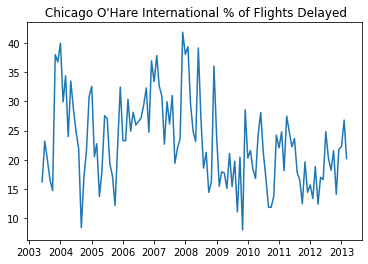

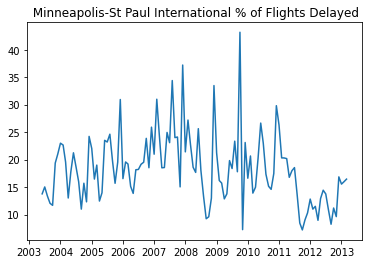

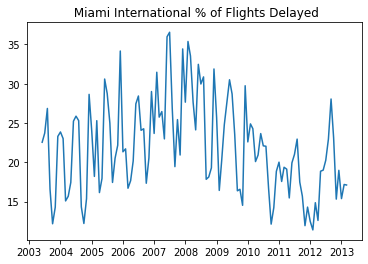

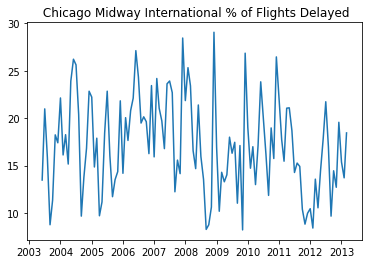

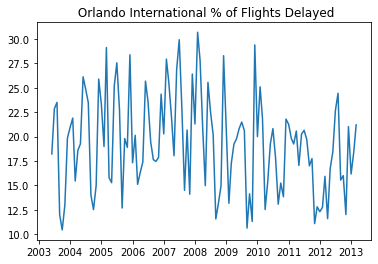

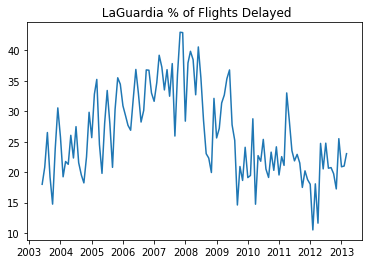

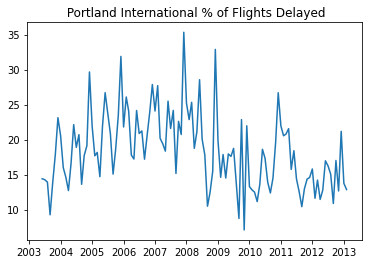

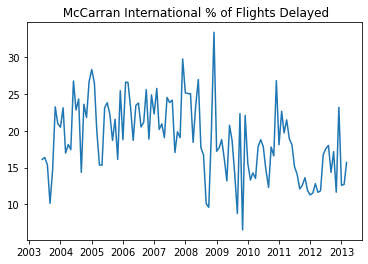

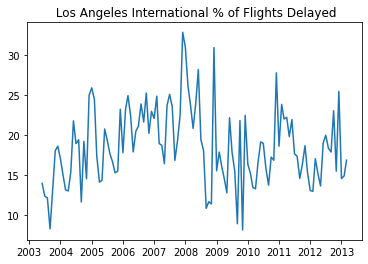

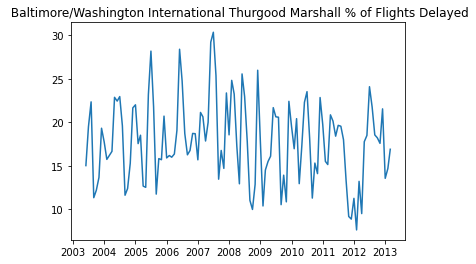

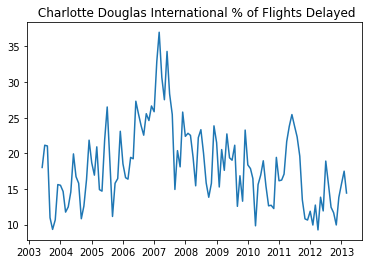

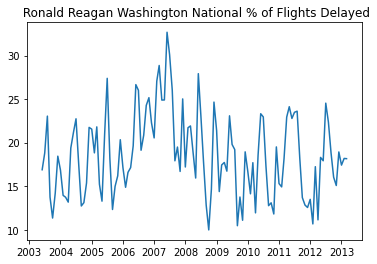

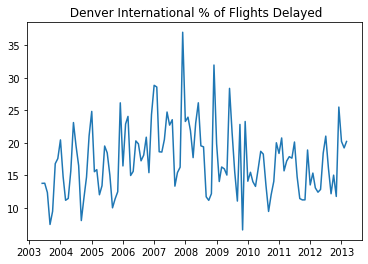

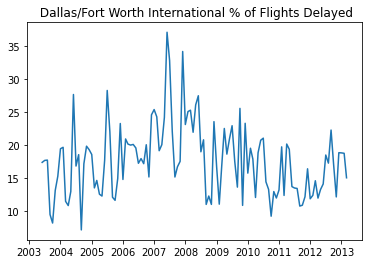

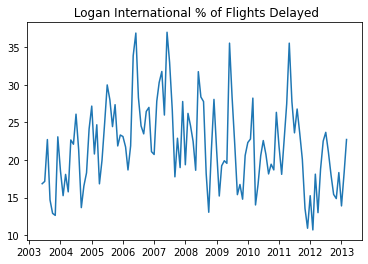

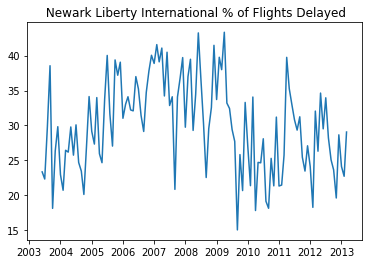

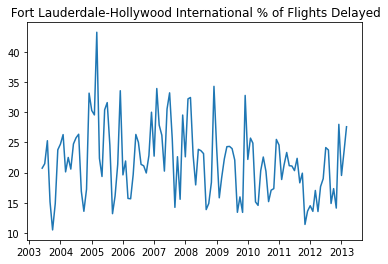

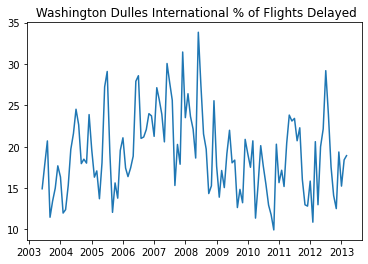

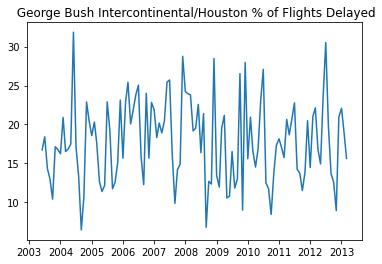

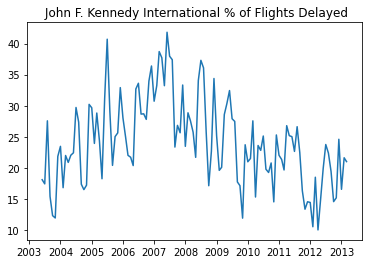

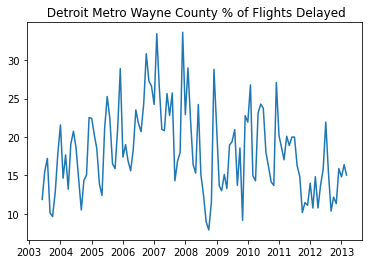

In [ ]:
# top 5 airports that have lowest chance of having a delayed flight

chances = {}


for airport_name in data['Airport.Name'].unique():
    subset = data[data['Airport.Name'] == airport_name]
    chance = subset['Statistics.Flights.Delayed'].sum() / subset['Statistics.Flights.Total'].sum()
    chances[airport_name] = chance

    chance_delay_over_time = 100 * subset['Statistics.Flights.Delayed']/subset['Statistics.Flights.Total']
    plt.plot(subset['Time.Label'], chance_delay_over_time)
    plt.title("{} % of Flights Delayed".format(airport_name))
    plt.show()

  

In [ ]:
# Follow-up:
## Is there an association between the chance of delay and how busy the airport is (i.e., how many total flights it has)
airport_chance_delay_dict = {k: v for k, v in sorted(chances.items(), key=lambda item: item[1])}
total_flights = data.groupby('Airport.Name').sum()['Statistics.Flights.Total'].loc[airport_chance_delay_dict.keys()]

display(np.corrcoef(list(airport_chance_delay_dict.values()), total_flights.values)[0,1])

-0.0056888772211674266

In [ ]:
po.Series(airport_chance_delay_dict)

 Salt Lake City International                            0.150310
 Phoenix Sky Harbor International                        0.163098
 Chicago Midway International                            0.173389
 Denver International                                    0.175961
 Dallas/Fort Worth International                         0.177066
 Baltimore/Washington International Thurgood Marshall    0.179197
 George Bush Intercontinental/Houston                    0.179234
 Charlotte Douglas International                         0.183684
 Detroit Metro Wayne County                              0.185233
 Portland International                                  0.185555
 Minneapolis-St Paul International                       0.185581
 San Diego International                                 0.186118
 Los Angeles International                               0.186794
 Ronald Reagan Washington National                       0.187247
 McCarran International                                  0.191795
 Washingto

In [ ]:
with open("outputs/airport-delay_chance.json", "w+") as outfile:
    json.dump(airport_chance_delay_dict, outfile)

Things to consider:
* There looks like there could be seasonality
  * E.g. number of on-time flights plummet during end of year (around holidays, harsh winter weather, etc.)
* Excluding stationarity, seems like it could be plausibly stationary (no clear trend, seems flat --> constant mean)


Other considerations:
* Bringing in latitude, longitude data to plot "hotspots" for delays, see if location is associated with amount of delays/ time of delays

# Data Manipulation

## Create a dictionary that has ‘Airport/Code’ as the keys and ‘Carriers/Names’ and ‘Carriers/Total’ as values; export this dictionary as a json file.

In [ ]:
subset = data[['Airport.Code','Statistics.Carriers.Names']]
names = (subset.groupby('Airport.Code')
         .agg(lambda g: {'Carriers/Names': list(unique_carriers(g)), 
                         'Carriers/Total':count_unique_carriers(g)
                        }
             )
        )
this_dictionary = names.iloc[:,0].to_dict()

print(this_dictionary)
with open("outputs/airport_codes-unique_carriers.json", "w+") as outfile:
    json.dump(this_dictionary, outfile)


{'ATL': {'Carriers/Names': ['atlantic coast airlines', 'american airlines inc.', 'atlantic southeast airlines', 'southwest airlines co.', 'jetblue airways', 'delta air lines inc.', 'independence air', 'airtran airways corporation', 'comair inc.', 'mesa airlines inc.', 'pinnacle airlines inc.', 'america west airlines inc.', 'frontier airlines inc.', 'expressjet airlines inc.', 'skywest airlines inc.', 'northwest airlines inc.', 'continental air lines inc.', 'united air lines inc.', 'us airways inc.', 'american eagle airlines inc.', 'alaska airlines inc.'], 'Carriers/Total': 21}, 'BOS': {'Carriers/Names': ['atlantic coast airlines', 'american airlines inc.', 'atlantic southeast airlines', 'ata airlines d/b/a ata', 'southwest airlines co.', 'jetblue airways', 'delta air lines inc.', 'independence air', 'airtran airways corporation', 'comair inc.', 'mesa airlines inc.', 'pinnacle airlines inc.', 'america west airlines inc.', 'frontier airlines inc.', 'expressjet airlines inc.', 'skywest ai

In [ ]:
with open("outputs/airport_codes-unique_carriers.json", "r+") as f:
    print(json.load(f))

{'ATL': {'Carriers/Names': ['atlantic coast airlines', 'american airlines inc.', 'atlantic southeast airlines', 'southwest airlines co.', 'jetblue airways', 'delta air lines inc.', 'independence air', 'airtran airways corporation', 'comair inc.', 'mesa airlines inc.', 'pinnacle airlines inc.', 'america west airlines inc.', 'frontier airlines inc.', 'expressjet airlines inc.', 'skywest airlines inc.', 'northwest airlines inc.', 'continental air lines inc.', 'united air lines inc.', 'us airways inc.', 'american eagle airlines inc.', 'alaska airlines inc.'], 'Carriers/Total': 21}, 'BOS': {'Carriers/Names': ['atlantic coast airlines', 'american airlines inc.', 'atlantic southeast airlines', 'ata airlines d/b/a ata', 'southwest airlines co.', 'jetblue airways', 'delta air lines inc.', 'independence air', 'airtran airways corporation', 'comair inc.', 'mesa airlines inc.', 'pinnacle airlines inc.', 'america west airlines inc.', 'frontier airlines inc.', 'expressjet airlines inc.', 'skywest ai

## Create a dataframe that has Airport, ‘Label’ (year/month), and ‘# of Delays’ (‘Late Aircraft’) as the values.
Plot the # of Delays due to late aircraft over time.
Which year/month had the most delays due to late aircraft? How about the least?
Which airport had the most delays all of 2010?


In [ ]:
df = (data[['Airport.Name', 'Time.Label', 'Statistics.# of Delays.Late Aircraft']]
      .rename(columns={'Airport.Name':'Airport', 
                       'Time.Label':'Label', 
                       'Statistics.# of Delays.Late Aircraft': '# of Delays (Late Aircraft)'
                      }
             )
)
df

,Airport,Label,# of Delays (Late Aircraft)
0,Hartsfield-Jackson Atlanta International,2003-06-01,1275
1,Tampa International,2003-06-01,327
2,Salt Lake City International,2003-06-01,290
3,San Francisco International,2003-06-01,312
4,Seattle/Tacoma International,2003-06-01,552
...,...,...,...
3409,Logan International,2013-03-01,756
3410,Hartsfield-Jackson Atlanta International,2013-03-01,2139
3411,Minneapolis-St Paul International,2013-03-01,665
3412,Fort Lauderdale-Hollywood International,2013-03-01,497


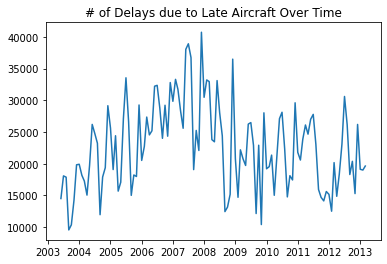

,# of Delays (Late Aircraft)
Label,
2003-06-01,14503
2003-07-01,18071
2003-08-01,17872
2003-09-01,9552
2003-10-01,10353


In [ ]:
# Plot the # of Delays due to late aircraft over time.
sum_late_aircraft = df.groupby('Label').sum()
t = df['Label'].unique()

plt.plot(t,sum_late_aircraft); plt.title("# of Delays due to Late Aircraft Over Time"); plt.show()
sum_late_aircraft.head()


In [ ]:
# Which year/month had the most delays due to late aircraft? How about the least? 

most_delays, least_delays = np.max(sum_late_aircraft.values),  np.min(sum_late_aircraft.values)

display("Most delays", sum_late_aircraft[sum_late_aircraft['# of Delays (Late Aircraft)'] == most_delays], 
        "Least delays", sum_late_aircraft[sum_late_aircraft['# of Delays (Late Aircraft)'] == least_delays]
)

'Most delays'

,# of Delays (Late Aircraft)
Label,
2007-12-01,40727


'Least delays'

,# of Delays (Late Aircraft)
Label,
2003-09-01,9552


In [ ]:
# Which airport had the most delays all of 2010?
df_2010 = df[df['Label'].apply(lambda date: date.year) == 2010]
df_2010.groupby('Airport').sum()['# of Delays (Late Aircraft)'].sort_values()

Airport
Portland International                                   3594
Ronald Reagan Washington National                        3710
Fort Lauderdale-Hollywood International                  4212
Miami International                                      4444
Philadelphia International                               4546
Tampa International                                      4549
Washington Dulles International                          4698
Seattle/Tacoma International                             4714
LaGuardia                                                4779
Newark Liberty International                             5518
John F. Kennedy International                            5523
San Diego International                                  5693
Charlotte Douglas International                          5816
Logan International                                      6537
Chicago Midway International                             7069
Minneapolis-St Paul International                        7967


Something to note: Salt Lake City is far from the airport with the least delays, yet we've already seen that SLC is actually the airport least likely to have a delay! This is yet another encouragement to analyze proportions, not absolute numbers, to determine whether an airport is "good".

## Using the excel file ‘airline-codes’, make a list of the airlines present in this dataset along with their corresponding codes.

In [ ]:
codes = po.read_excel("data/airline-codes.xlsx")
codes.head()

,Code,Airline
0,02Q,Titan Airways
1,04Q,Tradewind Aviation
2,05Q,"Comlux Aviation, AG"
3,06Q,Master Top Linhas Aereas Ltd.
4,07Q,Flair Airlines Ltd.


In [ ]:
# Get all unique airlines in dataframe
subset = data[['Airport.Name','Statistics.Carriers.Names']]

#subset.apply(unique_carriers)['Statistics.Carriers.Names']

In [ ]:
airlines_in_data = subset.apply(unique_carriers)['Statistics.Carriers.Names']
airlines_in_codes = po.Series(codes['Airline'].str.lower().unique())
display(airlines_in_data, airlines_in_codes)

{'airtran airways corporation',
 'alaska airlines inc.',
 'aloha airlines inc.',
 'america west airlines inc.',
 'american airlines inc.',
 'american eagle airlines inc.',
 'ata airlines d/b/a ata',
 'atlantic coast airlines',
 'atlantic southeast airlines',
 'comair inc.',
 'continental air lines inc.',
 'delta air lines inc.',
 'expressjet airlines inc.',
 'frontier airlines inc.',
 'hawaiian airlines inc.',
 'independence air',
 'jetblue airways',
 'mesa airlines inc.',
 'northwest airlines inc.',
 'pinnacle airlines inc.',
 'skywest airlines inc.',
 'southwest airlines co.',
 'united air lines inc.',
 'us airways inc.',
 'virgin america'}

0                       titan airways
1                  tradewind aviation
2                 comlux aviation, ag
3       master top linhas aereas ltd.
4                 flair airlines ltd.
                    ...              
1647      air wisconsin airlines corp
1648                     air georgian
1649                       airbc ltd.
1650           atlantic gulf airlines
1651             skyway aviation inc.
Length: 1652, dtype: object

In [ ]:
count = 0

airlines_found_in_codes = set()
airlines_not_found_in_codes = set()

for airline in airlines_in_data:

  # airline name in data is a substring of an airline found in codes,
  # OR an airline in codes is a substring of an airline name in data
    if any( airlines_in_codes.apply(lambda s: (airline in s) or (s in airline)) ):
        print(airline, "found in codes")
        airlines_found_in_codes.add(airline)
        count+=1

    else:
        print(airline, "not found in codes")
        airlines_not_found_in_codes.add(airline)

count, len(airlines_found_in_codes)

atlantic coast airlines not found in codes
american airlines inc. found in codes
atlantic southeast airlines found in codes
southwest airlines co. found in codes
ata airlines d/b/a ata found in codes
hawaiian airlines inc. found in codes
jetblue airways found in codes
delta air lines inc. found in codes
independence air found in codes
airtran airways corporation found in codes
comair inc. found in codes
mesa airlines inc. found in codes
pinnacle airlines inc. not found in codes
america west airlines inc. found in codes
frontier airlines inc. found in codes
expressjet airlines inc. found in codes
skywest airlines inc. found in codes
northwest airlines inc. found in codes
continental air lines inc. found in codes
aloha airlines inc. found in codes
virgin america found in codes
united air lines inc. found in codes
us airways inc. found in codes
american eagle airlines inc. found in codes
alaska airlines inc. found in codes


(23, 23)

In [ ]:
airlines_not_found_in_codes

{'atlantic coast airlines', 'pinnacle airlines inc.'}

Some exceptions: 
* atlantic coast airlines was previously known as atlantic coast jets
* pinnacle airlines is now known as Endeavor air

(Could web scrape to confirm these programmatically, but with only two exceptions it's not really worth it. It's easier to just google it manually!)

# Analysis

## Determine if there is a significant difference between the average number of flights delayed each month and the average number of flights cancelled each month.
Interpreted as: Average across all airports, for each month

In [ ]:
np.corrcoef(data['Statistics.Flights.Cancelled'].values, data['Statistics.Flights.Delayed'].values)[0,1]

0.7070094078101135

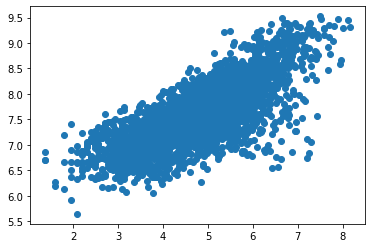

In [ ]:
plt.scatter(np.log(data['Statistics.Flights.Cancelled'].values), np.log(data['Statistics.Flights.Delayed'].values))

In [ ]:
d = data.groupby('Time.Label').mean()[['Statistics.Flights.Cancelled', 'Statistics.Flights.Delayed']]


In [ ]:
cancelled = np.log(d['Statistics.Flights.Cancelled'].values)
delayed = np.log(d['Statistics.Flights.Delayed'].values)

#n = cancelled.shape[0]
#cancelled_std = (cancelled - np.mean(cancelled))/np.std(cancelled) * np.sqrt(n)
#delayed_std = (delayed - np.mean(delayed))/np.std(delayed) * np.sqrt(n)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


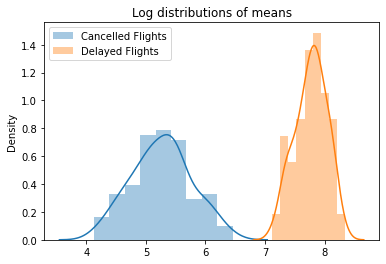

In [ ]:
import seaborn as sns
sns.distplot(cancelled, label='Cancelled Flights')
sns.distplot(delayed, label='Delayed Flights')
plt.title("Log distributions of means")
plt.legend()
plt.show()

# preliminary visualization: i hypothesize that these two distributions' means are significantly different from each other

In [ ]:
# Shapiro-Wilks Test to test approximately normal
from scipy.stats import shapiro

display(shapiro(cancelled), shapiro(delayed))

# we fail to reject the null hypothesis that the (log) distributions come from normal dist.

(0.9923873543739319, 0.7668246626853943)

(0.9850976467132568, 0.21913546323776245)

In [ ]:
from scipy.stats import ttest_ind

ttest_ind(delayed, cancelled, equal_var=False)

# yep, they're significantly different.

Ttest_indResult(statistic=47.86906464584573, pvalue=8.610832442624004e-104)

### Demo of shapiro test

In [ ]:
# test

from scipy.stats import norm

r = norm.rvs(loc=10, scale=5, size=cancelled.shape[0], random_state=42)
s = norm.rvs(loc=0, scale=1, size=cancelled.shape[0],random_state=420)
display(shapiro(r),
        shapiro(s),
        shapiro(r-s))

(0.992260754108429, 0.7553754448890686)

(0.9917739033699036, 0.7105343341827393)

(0.9919891357421875, 0.7304897904396057)

(array([ 1.,  6., 11., 12., 29., 32., 12.,  6.,  8.,  1.]),
 array([-3.09872552, -0.55723191,  1.9842617 ,  4.5257553 ,  7.06724891,
         9.60874252, 12.15023613, 14.69172974, 17.23322335, 19.77471695,
        22.31621056]),
 <a list of 10 Patch objects>)

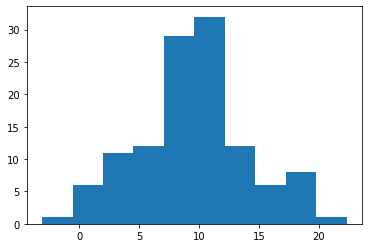

In [ ]:
plt.hist(r)

(array([ 5.,  6., 12., 27., 17., 16., 19.,  9.,  6.,  1.]),
 array([-2.24336739, -1.79033688, -1.33730637, -0.88427586, -0.43124535,
         0.02178516,  0.47481567,  0.92784618,  1.38087669,  1.8339072 ,
         2.28693771]),
 <a list of 10 Patch objects>)

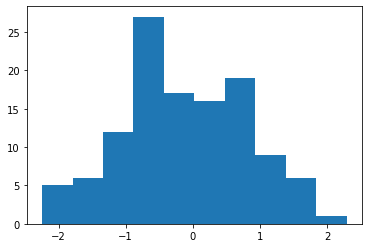

In [ ]:
plt.hist(s)

(array([ 1.,  1., 11.,  8., 25., 28., 24., 11.,  8.,  1.]),
 array([-4.75396773, -2.1080054 ,  0.53795693,  3.18391925,  5.82988158,
         8.47584391, 11.12180624, 13.76776857, 16.41373089, 19.05969322,
        21.70565555]),
 <a list of 10 Patch objects>)

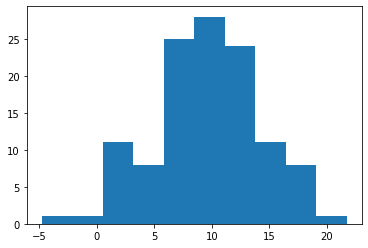

In [ ]:
plt.hist(r-s)

## Extract all fields in the ‘Minutes Delayed’ section by month. Split the year into four seasons: Dec-Feb, March-May, June-Aug, Sept-Nov. 
Is there a relationship between minutes delayed (by category) and season?


In [ ]:
def seasonalize(date):
  if date.month in [12,1,2]:
    return "Winter"
  if date.month in [3,4,5]:
    return "Spring"
  if date.month in [6,7,8]:
    return "Summer"
  if date.month in [9,10,11]:
    return "Fall"

data['Time.Season'] = data['Time.Label'].apply(seasonalize)
data['Time.Season']

0       Summer
1       Summer
2       Summer
3       Summer
4       Summer
         ...  
3409    Spring
3410    Spring
3411    Spring
3412    Spring
3413    Spring
Name: Time.Season, Length: 3414, dtype: object

In [ ]:
display(
    data[['Statistics.# of Delays.Carrier',
       'Statistics.# of Delays.Late Aircraft',
       'Statistics.# of Delays.National Aviation System',
       'Statistics.# of Delays.Security', 
       'Statistics.# of Delays.Weather']].sum().sum(),
    data['Statistics.Flights.Delayed'].sum()
)

# discrepancy between # of delays, and the # of flights delayed (# of delays > flights delayed, implying a flight could have multiple reasons for delay)

8391284

8390912

In [ ]:
# ns is essentially a mapper of the season to the season's total number of delays 

ns = data["Statistics.# of Delays.Total"]

ns.index = data['Time.Season']
ns = ns.groupby('Time.Season').sum()
ns

Time.Season
Fall      1738200
Spring    1939792
Summer    2440354
Winter    2272938
Name: Statistics.# of Delays.Total, dtype: int64

In [ ]:
subset = data[[
               'Statistics.# of Delays.Carrier',
               'Statistics.# of Delays.Late Aircraft',
               'Statistics.# of Delays.National Aviation System',
               'Statistics.# of Delays.Security', 
               'Statistics.# of Delays.Weather']]

subset.index = data["Time.Season"]
subset

,Statistics.# of Delays.Carrier,Statistics.# of Delays.Late Aircraft,Statistics.# of Delays.National Aviation System,Statistics.# of Delays.Security,Statistics.# of Delays.Weather
Time.Season,,,,,
Summer,1009,1275,3217,17,328
Summer,226,327,524,3,42
Summer,363,290,352,15,36
Summer,416,312,1080,14,59
Summer,448,552,454,28,36
...,...,...,...,...,...
Spring,515,756,775,3,43
Spring,1182,2139,1990,3,165
Spring,452,665,876,2,79


In [ ]:
# looking at number of each type of delay, for each season
subset.groupby(subset.index).sum()


,Statistics.# of Delays.Carrier,Statistics.# of Delays.Late Aircraft,Statistics.# of Delays.National Aviation System,Statistics.# of Delays.Security,Statistics.# of Delays.Weather
Time.Season,,,,,
Fall,402099,513664,772648,3681,46108
Spring,447014,619708,812287,4342,56441
Summer,586142,815260,938836,6747,93369
Winter,531346,722794,929144,6358,83296


Looks like Fall has least number of delays due to Carrier. 
One can reasonably conclude Fall is the best season to fly. 
But this is not taking into account the fact that there are fewer overall flights in Fall, compared to e.g. Spring

Similarly, one can conclude that Summer is the most dangerous, because there's so many delays due to security.
However, for the same reason, this is not necessarily the case as we will see below.

In [ ]:
# looking at PROPORTIONS of each type of delay, for each season
subset.groupby(subset.index).agg(lambda g: g.sum() / ns[np.unique(g.index)])


,Statistics.# of Delays.Carrier,Statistics.# of Delays.Late Aircraft,Statistics.# of Delays.National Aviation System,Statistics.# of Delays.Security,Statistics.# of Delays.Weather
Time.Season,,,,,
Fall,0.231331,0.295515,0.444510,0.002118,0.026526
Spring,0.230444,0.319471,0.418750,0.002238,0.029096
Summer,0.240187,0.334074,0.384713,0.002765,0.038260
Winter,0.233771,0.318000,0.408785,0.002797,0.036647


Above, we surmised Fall was the best season to fly. Looking at the proportions though, Spring has the least proportion of delays (due to Carrier).

Additionally, in terms of security, the proportion of flights delayed due to that seems roughly equivalent across all seasons.

(In general, rates are more informative than absolute numbers (population))

looking at absolute numbers doesn't give full picture;
doesn't tell you how "frequent" the delays are.

Surprisingly, the number of delays due to weather doesn't seem to be significantly higher in the winter vs. the summer.

In [ ]:
# Additional visualizations
# plotting number of delays per season, over time (year)

subset = data[['Time.Year',
               'Time.Season',
               'Statistics.# of Delays.Carrier',
               'Statistics.# of Delays.Late Aircraft',
               'Statistics.# of Delays.National Aviation System',
               'Statistics.# of Delays.Security', 
               'Statistics.# of Delays.Weather']]


subset.groupby(['Time.Year', 'Time.Season']).sum()

Statistics.# of Delays.Carrier  \
Time.Year Time.Season                                   
2003      Fall                                  29375   
          Summer                                41113   
          Winter                                16675   
2004      Fall                                  40084   
          Spring                                39434   
          Summer                                55751   
          Winter                                53591   
2005      Fall                                  45247   
          Spring                                47529   
          Summer                                65275   
          Winter                                60654   
2006      Fall                                  56305   
          Spring                                55582   
          Summer                                71272   
          Winter                                60843   
2007      Fall                                  51140   
          Spring                                66211   
          Summer                                79857   
          Winter                                76026   
2008      Fall                                  34301   
          Spring                                56725   
          Summer                                61545   
          Winter                                64693   
2009      Fall                                  35063   
          Spring                                41802   
          Summer                                52675   
          Winter                                44645   
2010      Fall                                  36181   
          Spring                                41876   
          Summer                                53038   
          Winter                                47395   
2011      Fall                                  34090   
          Spring                                46745   
          Summer                                51612   
          Winter                                41186   
2012      Fall                                  40313   
          Spring                                39048   
          Summer                                54004   
          Winter                                38797   
2013      Spring                                12062   
          Winter                                26841   

                       Statistics.# of Delays.Late Aircraft  \
Time.Year Time.Season                                         
2003      Fall                                        34153   
          Summer                                      50446   
          Winter                                      19822   
2004      Fall                                        49214   
          Spring                                      51999   
          Summer                                      74190   
          Winter                                      67222   
2005      Fall                                        51194   
          Spring                                      57155   
          Summer                                      87265   
          Winter                                      73946   
2006      Fall                                        77544   
          Spring                                      77078   
          Summer                                      93332   
          Winter                                      76025   
2007      Fall                                        66385   
          Spring                                      85610   
          Summer                                     113668   
          Winter                                     103857   
2008      Fall                                        40765   
          Spring                                      80184   
          Summer                                      85555   
          Winter                                     100157

In [ ]:
year_season_num_delays = subset.groupby(['Time.Year', 'Time.Season']).sum()[['Statistics.# of Delays.Carrier']]
year_season_num_delays

Statistics.# of Delays.Carrier
Time.Year Time.Season                                
2003      Fall                                  29375
          Summer                                41113
          Winter                                16675
2004      Fall                                  40084
          Spring                                39434
          Summer                                55751
          Winter                                53591
2005      Fall                                  45247
          Spring                                47529
          Summer                                65275
          Winter                                60654
2006      Fall                                  56305
          Spring                                55582
          Summer                                71272
          Winter                                60843
2007      Fall                                  51140
          Spring                                66211
          Summer                                79857
          Winter                                76026
2008      Fall                                  34301
          Spring                                56725
          Summer                                61545
          Winter                                64693
2009      Fall                                  35063
          Spring                                41802
          Summer                                52675
          Winter                                44645
2010      Fall                                  36181
          Spring                                41876
          Summer                                53038
          Winter                                47395
2011      Fall                                  34090
          Spring                                46745
          Summer                                51612
          Winter                                41186
2012      Fall                                  40313
          Spring                                39048
          Summer                                54004
          Winter                                38797
2013      Spring                                12062
          Winter                                26841

In [ ]:
year_season_num_delays.loc[2003, 'Fall']

Statistics.# of Delays.Carrier    29375
Name: (2003, Fall), dtype: int64

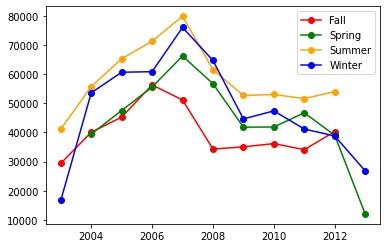

In [ ]:
season_xy = {season:[] for season in ['Fall', 'Spring', 'Summer', 'Winter']}
for year, season in year_season_num_delays.index:
  season_xy[season].append((year, year_season_num_delays.loc[year, season]))

colors = ['Red', 'Green', 'Orange', 'Blue']


for season, points, color in zip(season_xy.keys(), season_xy.values(), colors):
  d = po.DataFrame(points, columns=['Year', '# Delays'])
  plt.plot(d['Year'], d['# Delays'], marker = 'o', color=color, label=season)

plt.legend()
plt.show()

In [ ]:
season_xy

{'Fall': [(2003, Statistics.# of Delays.Carrier    29375
   Name: (2003, Fall), dtype: int64),
  (2004, Statistics.# of Delays.Carrier    40084
   Name: (2004, Fall), dtype: int64),
  (2005, Statistics.# of Delays.Carrier    45247
   Name: (2005, Fall), dtype: int64),
  (2006, Statistics.# of Delays.Carrier    56305
   Name: (2006, Fall), dtype: int64),
  (2007, Statistics.# of Delays.Carrier    51140
   Name: (2007, Fall), dtype: int64),
  (2008, Statistics.# of Delays.Carrier    34301
   Name: (2008, Fall), dtype: int64),
  (2009, Statistics.# of Delays.Carrier    35063
   Name: (2009, Fall), dtype: int64),
  (2010, Statistics.# of Delays.Carrier    36181
   Name: (2010, Fall), dtype: int64),
  (2011, Statistics.# of Delays.Carrier    34090
   Name: (2011, Fall), dtype: int64),
  (2012, Statistics.# of Delays.Carrier    40313
   Name: (2012, Fall), dtype: int64)],
 'Spring': [(2004, Statistics.# of Delays.Carrier    39434
   Name: (2004, Spring), dtype: int64),
  (2005, Statistics.# 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  


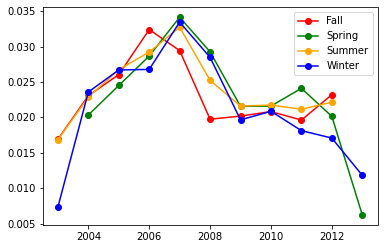

In [ ]:
subset.index = subset['Time.Season']
year_season_prop_delays = subset.groupby(['Time.Year', subset.index]).agg(lambda g: g.sum() / ns[np.unique(g.index)])['Statistics.# of Delays.Carrier']
season_xy = {season:[] for season in ['Fall', 'Spring', 'Summer', 'Winter']}
for year, season in year_season_prop_delays.index:
    season_xy[season].append((year, year_season_prop_delays[year, season]))

colors = ['Red', 'Green', 'Orange', 'Blue']

for season, points, color in zip(season_xy.keys(), season_xy.values(), colors):
    d = po.DataFrame(points, columns=['Year', '# Delays'])
    plt.plot(d['Year'], d['# Delays'], marker = 'o', color = color, label=season)

plt.legend()
plt.show()

## If a flight at ATL has a delay, what is the probability that the delay is due to… Weather? Late Aircraft?


In [ ]:
atl_data = data[data['Airport.Code'] == 'ATL']
atl_data.head()

,Airport.Code,Airport.Location,Airport.Name,Statistics.# of Delays.Carrier,Statistics.# of Delays.Late Aircraft,Statistics.# of Delays.National Aviation System,Statistics.# of Delays.Security,Statistics.# of Delays.Total,Statistics.# of Delays.Weather,Statistics.Carriers.Names,...,Statistics.Minutes Delayed.Late Aircraft,Statistics.Minutes Delayed.National Aviation System,Statistics.Minutes Delayed.Security,Statistics.Minutes Delayed.Total,Statistics.Minutes Delayed.Weather,Time.Label,Time.Month,Time.Month Name,Time.Year,Time.Season
0,ATL,"Atlanta, GA",Hartsfield-Jackson Atlanta International,1009,1275,3217,17,5846,328,"American Airlines Inc.,JetBlue Airways,Contine...",...,68335,118831,518,268764,19474,2003-06-01,6,June,2003,Summer
51,ATL,"Atlanta, GA",Hartsfield-Jackson Atlanta International,1259,1791,4022,13,7452,367,"American Airlines Inc.,JetBlue Airways,Contine...",...,116728,184740,356,418274,29189,2003-07-01,7,July,2003,Summer
75,ATL,"Atlanta, GA",Hartsfield-Jackson Atlanta International,1220,1766,4475,9,7831,361,"American Airlines Inc.,JetBlue Airways,Contine...",...,108114,163912,304,370130,20758,2003-08-01,8,August,2003,Summer
103,ATL,"Atlanta, GA",Hartsfield-Jackson Atlanta International,700,807,2267,4,3939,161,"American Airlines Inc.,JetBlue Airways,Contine...",...,42031,82737,180,180656,9852,2003-09-01,9,September,2003,Fall
138,ATL,"Atlanta, GA",Hartsfield-Jackson Atlanta International,756,906,3355,4,5191,170,"American Airlines Inc.,JetBlue Airways,Contine...",...,41875,111361,188,210846,8601,2003-10-01,10,October,2003,Fall


In [ ]:
total_num_delays = atl_data['Statistics.# of Delays.Total'].sum()

total_num_delays

872883

In [ ]:
# empirical chance

atl_data['Statistics.# of Delays.Weather'].sum() / total_num_delays

0.04002025471913189

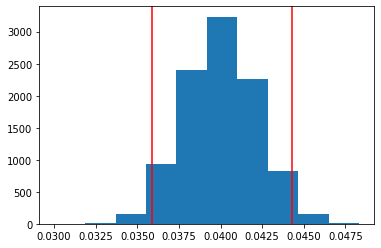

In [ ]:
n = atl_data.shape[0]
total_num_delays_no_weather = (atl_data['Statistics.# of Delays.Total'] - atl_data['Statistics.# of Delays.Weather']).sum()

chances = []

for _ in range(10000):
  random_sum_boot = np.sum(np.random.choice(atl_data['Statistics.# of Delays.Weather'].values, size=n))
  chances.append(random_sum_boot / (random_sum_boot + total_num_delays_no_weather))

plt.hist(chances)

lower, upper = np.percentile(chances, 2.5), np.percentile(chances, 97.5)
plt.axvline(upper, color='red')
plt.axvline(lower, color='red')

In [ ]:
# empirical chance

atl_data['Statistics.# of Delays.Late Aircraft'].sum() / total_num_delays

0.27416045449390125

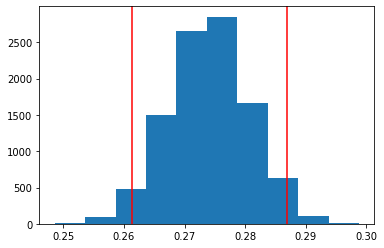

In [ ]:
n = atl_data.shape[0]
total_num_delays_no_late_aircraft = (atl_data['Statistics.# of Delays.Total'] - atl_data['Statistics.# of Delays.Late Aircraft']).sum()

chances = []

for _ in range(10000):
  random_sum_boot = np.sum(np.random.choice(atl_data['Statistics.# of Delays.Late Aircraft'].values, size=n))
  chances.append(random_sum_boot / (random_sum_boot + total_num_delays_no_late_aircraft))

plt.hist(chances)

lower, upper = np.percentile(chances, 2.5), np.percentile(chances, 97.5)
plt.axvline(upper, color='red')
plt.axvline(lower, color='red')

# Miscellaneous/Playground

In [ ]:
# more helpful metrics:
# top 5 airports that have the greatest chance of being delayed due to security (e.g., most unsafe airport)
# top 5 airports that have the greatest chance of being on time (# on time flights / # flights total)
# top 5 airports that have the lowest chance of having a delayed flight (# delayed flights / # flights total)
# top 5 airports with the lowest average delay per flight (# minutes delayed / # flights delayed)

## Average length of delays per airport

In [ ]:
# average length of delays, per airport
data['Statistics.Custom.Average Length of Delay.Total'] = data['Statistics.Minutes Delayed.Total'].values/data['Statistics.# of Delays.Total'].values
data['Statistics.Custom.Average Length of Delay.Total'].describe()

count    3414.000000
mean       53.232396
std         8.217375
min        34.693396
25%        47.120287
50%        51.942038
75%        58.078129
max        89.254730
Name: Statistics.Custom.Average Length of Delay.Total, dtype: float64

In [ ]:
data.groupby('Airport.Name').mean()['Statistics.Custom.Average Length of Delay.Total'].sort_values()


Airport.Name
 San Diego International                                 45.873711
 Phoenix Sky Harbor International                        46.830717
 Salt Lake City International                            46.853984
 Charlotte Douglas International                         47.085209
 McCarran International                                  47.902802
 Portland International                                  48.243953
 Seattle/Tacoma International                            48.761680
 Los Angeles International                               48.959071
 Chicago Midway International                            49.893327
 Tampa International                                     49.979803
 Ronald Reagan Washington National                       50.349900
 Fort Lauderdale-Hollywood International                 50.553301
 Denver International                                    50.691749
 Orlando International                                   51.240398
 Baltimore/Washington International Thurgood Mars

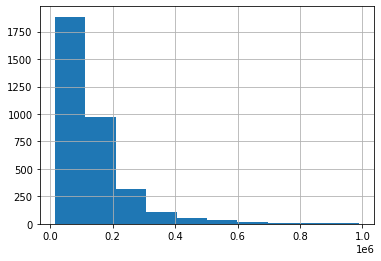

None

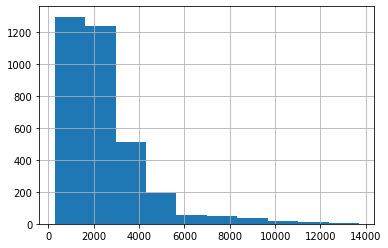

In [ ]:
display(data['Statistics.Minutes Delayed.Total'].hist(),plt.show(), data['Statistics.# of Delays.Total'].hist())

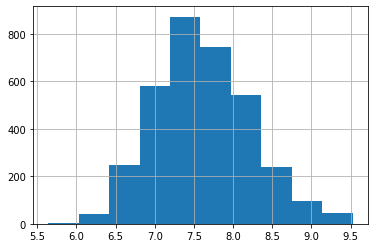

In [ ]:
np.log(data['Statistics.# of Delays.Total']).hist()

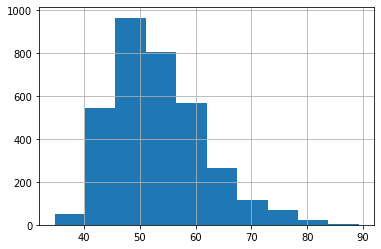

In [ ]:
data['Statistics.Custom.Average Length of Delay.Total'].hist()

## Time Series stuff

In [86]:
time_series = data.groupby('Time.Label').mean()
time_series

,Statistics.# of Delays.Carrier,Statistics.# of Delays.Late Aircraft,Statistics.# of Delays.National Aviation System,Statistics.# of Delays.Security,Statistics.# of Delays.Total,Statistics.# of Delays.Weather,Statistics.Carriers.Total,Statistics.Flights.Cancelled,Statistics.Flights.Delayed,Statistics.Flights.Diverted,Statistics.Flights.On Time,Statistics.Flights.Total,Statistics.Minutes Delayed.Carrier,Statistics.Minutes Delayed.Late Aircraft,Statistics.Minutes Delayed.National Aviation System,Statistics.Minutes Delayed.Security,Statistics.Minutes Delayed.Total,Statistics.Minutes Delayed.Weather,Time.Month,Time.Year
Time.Label,,,,,,,,,,,,,,,,,,,,
2003-06-01,420.689655,500.103448,890.413793,10.965517,1904.379310,82.206897,11.586207,85.793103,1903.448276,24.344828,9446.413793,11460.000000,23378.551724,27180.551724,34669.655172,492.517241,91149.551724,5428.275862,6.0,2003.0
2003-07-01,495.310345,623.137931,970.620690,7.379310,2198.448276,102.000000,11.689655,168.655172,2198.137931,29.275862,9548.344828,11944.413793,29415.172414,39837.896552,47033.413793,194.758621,124665.862069,8184.620690,7.0,2003.0
2003-08-01,501.689655,616.275862,1043.448276,8.241379,2285.275862,115.620690,11.758621,206.241379,2285.655172,39.206897,9390.241379,11921.344828,30482.310345,39667.482759,51856.103448,294.482759,131400.344828,9099.965517,8.0,2003.0
2003-09-01,294.551724,329.379310,794.344828,2.172414,1465.793103,45.344828,11.689655,178.965517,1465.965517,17.344828,9628.724138,11291.000000,16318.620690,18016.344828,34642.586207,65.586207,72284.689655,3241.413793,9.0,2003.0
2003-10-01,336.034483,357.000000,768.931034,5.655172,1502.586207,34.965517,11.896552,112.551724,1501.551724,15.586207,10224.655172,11854.344828,18608.034483,18697.793103,28023.448276,245.241379,68148.689655,2574.172414,10.0,2003.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-01,413.620690,526.896552,461.310345,2.413793,1430.000000,25.758621,10.793103,123.758621,1429.965517,15.241379,9358.965517,10927.931034,25950.137931,32084.862069,19372.896552,83.344828,80150.000000,2658.758621,11.0,2012.0
2012-12-01,604.620690,903.000000,780.068966,6.310345,2353.068966,59.068966,10.724138,170.586207,2353.310345,21.241379,8535.344828,11080.482759,37897.793103,58005.344828,35204.275862,226.965517,136187.482759,4852.827586,12.0,2012.0
2013-01-01,480.586207,659.068966,710.620690,4.241379,1910.137931,55.620690,11.517241,160.827586,1910.931034,21.000000,9204.241379,11297.000000,31970.965517,40409.896552,28656.551724,152.931034,106139.241379,4948.758621,1.0,2013.0


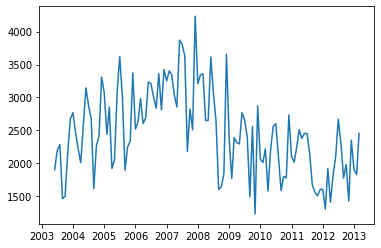

In [87]:
plt.plot(time_series['Statistics.# of Delays.Total'])

In [88]:
from statsmodels.tsa.stattools import adfuller

#perform augmented Dickey-Fuller test to test stationarity
adfuller(time_series['Statistics.# of Delays.Total'].values)

# p-value is .81, fail to reject null (null states data is non-stationary) => non-stationary ts --> look at acf, pacf plots --> fit ARMA or ARIMA

(-0.8189189662331096,
 0.8135015011402755,
 12,
 105,
 {'1%': -3.4942202045135513,
  '10%': -2.5816762131519275,
  '5%': -2.889485291005291},
 1560.740691677486)

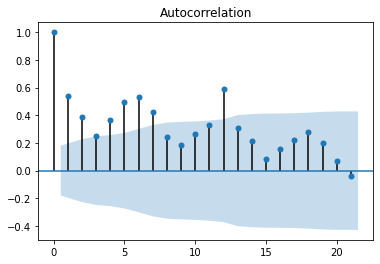

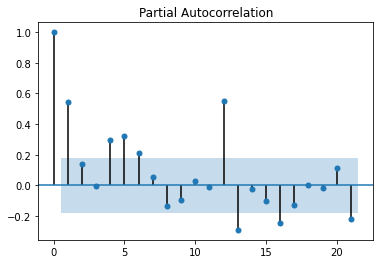

In [89]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(time_series['Statistics.# of Delays.Total'].values);
plot_pacf(time_series['Statistics.# of Delays.Total'].values);


In [90]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

my_order = (1, 0, 0)
my_seasonal_order = (1, 0, 1, 12)

model = SARIMAX(time_series['Statistics.# of Delays.Total'].values, order=my_order, seasonal_order=my_seasonal_order)

model_fitted = model.fit()

In [91]:
forecasts = model_fitted.get_forecast(12) # forecast 12 months, or 1 year, ahead
forecasts.predicted_mean, forecasts.conf_int()

(array([2117.41892574, 2258.52372137, 2541.83670323, 2659.23527908,
        2315.05663844, 1720.28196172, 1909.70737895, 1578.35160318,
        2353.15781523, 1918.76292584, 1767.1060992 , 2173.66498822]),
 array([[1337.19168459, 2897.64616689],
        [1230.02282886, 3287.02461389],
        [1363.25349477, 3720.41991169],
        [1381.18250136, 3937.28805679],
        [ 968.32573421, 3661.78754267],
        [ 325.05230991, 3115.51161352],
        [ 479.7542783 , 3339.66047961],
        [ 123.31438293, 3033.38882342],
        [ 879.89029988, 3826.42533057],
        [ 432.19100246, 3405.33484923],
        [ 270.79645014, 3263.41574827],
        [ 670.21378356, 3677.11619287]]))

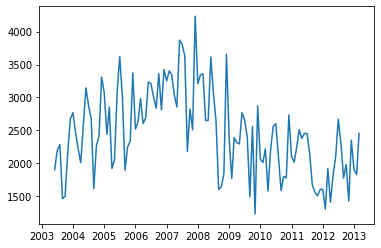

In [92]:
plt.plot(time_series.index, time_series['Statistics.# of Delays.Total'])

In [107]:
import datetime as dt
from dateutil.relativedelta import relativedelta
ts = list(time_series.index)
future_ts = [ts[-1] + relativedelta(months=i) for i in range(1, 12+1)]
#ts.extend(future_ts)

vals = time_series['Statistics.# of Delays.Total'].tolist()
future_vals = (forecasts.predicted_mean)

confint = forecasts.conf_int()
lower, upper = confint[:,0], confint[:,1]
#vals.extend(future_vals)

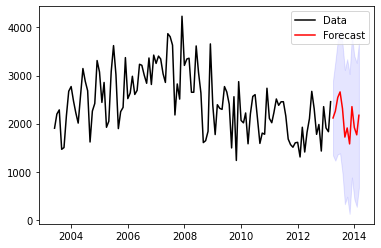

In [108]:
plt.plot(ts, vals, color='black', label='Data')
plt.plot(future_ts, future_vals, color='red', label='Forecast')
plt.fill_between(future_ts, lower, upper, color='blue', alpha=0.1)
plt.legend()

Ideally, use forecasts to plan future travel plans.